<a href="https://colab.research.google.com/github/ykitaguchi77/GAN/blob/master/CLIP_%2B_TADNE_(pytorch)_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##readme

This notebook was created by Logan Zoellner (@nagolinc, https://loganzoellner.com)


This notebook makes use of @AydaoAI's "This Anime Does not exist" (which you can read more about here: https://www.gwern.net/Faces#extended-stylegan2-danbooru2019-aydao) and CLIP (which you can read more about here https://github.com/openai/CLIP).

Much of it was based off of this notebook: https://colab.research.google.com/github/openai/clip/blob/master/Interacting_with_CLIP.ipynb created by @openai

And this notebook: https://colab.research.google.com/drive/1oxcJ1tbG77hlggdKd_d8h22nBcIZsLTL by @arfa

TADNE is under a CC BY-NC liscence and CLIP is under the MIT Liscence.

Any code in this notebook not otherwise liscenced is herein released under the MIT Liscence.

#Import TADNE and convert to pytorch

In [2]:
!git clone https://github.com/shawwn/stylegan2 -b estimator /content/stylegan2

fatal: destination path '/content/stylegan2' already exists and is not an empty directory.


In [3]:
cd /content/

/content


In [4]:
import gdown, os

#モデルをダウンロード
if not os.path.exists("/content/network-tadne.pkl"):
  #gdown.download('https://drive.google.com/uc?id=1qNhyusI0hwBLI-HOavkNP5I0J0-kcN4C', 'network-tadne.pkl', quiet=False)
  url='https://drive.google.com/uc?id=1LCkyOPmcWBsPlQX_DxKAuPM1Ew_nh83I'
  gdown.download(url, '/content/network-tadne.pkl', quiet=False)

!ls -lrt /content/network-tadne.pkl

-rw-r--r-- 1 root root 1056544230 Jul  2 00:09 /content/network-tadne.pkl


In [5]:
%tensorflow_version 1.x
%cd /content/stylegan2 #ここでランタイムの再起動を求められる

TensorFlow 1.x selected.
/content/stylegan2


In [7]:
import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import scipy

#モデルをロードする
tflib.init_tf()
_G, _D, Gs = pickle.load(open("/content/network-tadne.pkl", "rb"))
# _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
# _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [8]:

!git clone https://github.com/nagolinc/stylegan2-pytorch.git /content/stylegan2-pytorch/
!cd /content/stylegan2-pytorch/
!git pull

Cloning into '/content/stylegan2-pytorch'...
remote: Enumerating objects: 380, done.
remote: Total 380 (delta 0), reused 0 (delta 0), pack-reused 380
Receiving objects: 100% (380/380), 122.50 MiB | 27.84 MiB/s, done.
Resolving deltas: 100% (196/196), done.
Already up to date.


In [9]:
import subprocess

#CUDAのセットアップ
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install ninja
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 14.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.4 MB/s eta 0:03:52tcmalloc: large alloc 1147494400 bytes == 0x39846000 @  0x7f631bb52615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.3 MB/s eta 0:01:21tcmalloc: large alloc 1434370048 bytes == 0x7de9c000 @  0x7f631bb52615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127

#**TensorflowのモデルをPytorch用に変換**

In [10]:
%cd /content/stylegan2-pytorch
from convert_weight import convertStyleGan2

#tfのモデルをPytorch用に変換
ckpt, g, disc,g_train = convertStyleGan2(_G,_D,Gs)
latent_avg=ckpt["latent_avg"]

/content/stylegan2-pytorch


In [11]:
import torch
import matplotlib.pyplot as plt

#
def fmtImg(r):
    img = ((r+1)/2*256).clip(0,255).astype(np.uint8).transpose(1,2,0)
    return PIL.Image.fromarray(img, 'RGB')

In [16]:
device='cuda'
n_sample=1

g = g.to(device)

inputSize=1024

#[1,1024]の行列を作成
z = np.random.RandomState(1).randn(n_sample, inputSize).astype("float32")

##################
##Pytorchによる生成
##################
with torch.no_grad():
    img_pt, _ = g(
        [torch.from_numpy(z).to(device)],
        truncation=0.5,
        truncation_latent=latent_avg.to(device),
        randomize_noise=False,
    )

###################
## Tensorflowによる生成
###################
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.randomize_noise = False
#img_tf = g_ema.run(z, None, **Gs_kwargs)
img_tf = Gs.run(z, None, **Gs_kwargs)
img_tf = torch.from_numpy(img_tf).to(device)

In [ ]:
#verify that these images match
#TensorflowとPytorchによる生成画像が一致することを確認
img=img_pt.cpu().numpy()[0]
display(fmtImg(img))
img = img_tf.cpu().numpy()[0]
display(fmtImg(img))

In [18]:
#and do we get the same output for D and disc?
device='cuda'

img=img_tf.cpu().numpy()
score0=_D.run(img,None)
disc.to(device)
with torch.no_grad():
    score1 = disc(
          torch.from_numpy(img).to(device)
    )
#verify that these scores match
print(score0,score1)

[[-1.527499]] tensor([[-1.5275]], device='cuda:0')


#Import CLIP

In [ ]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [ ]:
! wget {MODELS["ViT-B/32"]} -O model.pt

--2021-01-24 00:26:02--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  72.5MB/s    in 4.8s    

2021-01-24 00:26:07 (70.1 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [ ]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.



In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

## Text Preprocessing

We use a case-insensitive tokenizer. The tokenizer code is hidden in the second cell below

In [ ]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-01-24 00:26:10--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.13, 2620:1ec:bdf::13
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.08s   

2021-01-24 00:26:10 (17.2 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


#Gradient Descent
We calculate a score based off of:
1. Clip score for the description string
2. Discriminator score from TADNE
3. Regularize, since TADNE expects inputs that are unit normal

In [ ]:
from tqdm.notebook import tqdm, trange

In [ ]:
_preprocess = torch.nn.Sequential(
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
)


In [ ]:
def getScoringFunction(description,phi=1.0,regularization=-0.01/1024,discriminatorWeight=0.001):
  #preprocess text
  texts=[description]  
  tokenizer = SimpleTokenizer()
  text_tokens = [tokenizer.encode("This is " + desc) for desc in texts]
  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  for i, tokens in enumerate(text_tokens):
      text_input[i, :len(tokens)] = torch.tensor(tokens)
  text_input = text_input.cuda()

  #this function takes a (latent) as input and returns a PIL image
  # latents can be generated using 
  # latent = np.random.RandomState(seed).randn(1, 1024)
  def displayLatent(latent,phi=phi):
    with torch.no_grad():
      img_pt, _ = g(
          [torch.from_numpy(latent).to(device)],
          truncation=phi,
          truncation_latent=latent_avg.to(device),
          randomize_noise=False,
      )
    img=img_pt.cpu().numpy()[0]
    return fmtImg(img)
  
  #this function takes a latent and returns a score and a derivative
  def scoreLatent(latent,phi=phi,regularization=regularization,discriminatorWeight=discriminatorWeight):
    with torch.no_grad():
      _latent=torch.from_numpy(latent).to(device)
      #compute img array from latent
      img_pt, _ = g(
          [_latent],
          truncation=phi,
          truncation_latent=latent_avg.to(device),
          randomize_noise=False,
      )
      #pass through CLIP
      image_input = _preprocess(img_pt)
      image_features = model.encode_image(image_input).float()
      text_features = model.encode_text(text_input).float()    
      #cosine
      image_features_n= image_features/image_features.norm(dim=-1, keepdim=True)
      text_features_n=text_features/text_features.norm(dim=-1, keepdim=True)
      similarity = text_features_n @ image_features_n.T
      #clip score is just the similarity
      clipScore=similarity.sum()
      #discriminator
      discScore=disc(img_pt)
      #regularization
      l2reg=(_latent**2).sum()
      loss=l2reg*regularization-discScore*discriminatorWeight-clipScore
    score=loss.cpu().numpy().flatten()[0][0]
    return score

  def scoreLatent3(latent,phi=phi,regularization=regularization,discriminatorWeight=discriminatorWeight):
    with torch.no_grad():
      _latent=torch.from_numpy(latent).to(device)
      #compute img array from latent
      img_pt, _ = g(
          [_latent],
          truncation=phi,
          truncation_latent=latent_avg.to(device),
          randomize_noise=False,
      )
      #pass through CLIP
      image_input = _preprocess(img_pt)
      image_features = model.encode_image(image_input).float()
      text_features = model.encode_text(text_input).float()    
      #cosine
      image_features_n= image_features/image_features.norm(dim=-1, keepdim=True)
      text_features_n=text_features/text_features.norm(dim=-1, keepdim=True)
      similarity = text_features_n @ image_features_n.T
      #clip score is just the similarity
      clipScore=similarity.sum()
      #discriminator
      discScore=disc(img_pt)
      #regularization
      l2reg=(_latent**2).sum()
      loss=l2reg*regularization-discScore*discriminatorWeight-clipScore
    return clipScore.cpu().item(),discScore.cpu().numpy()[0][0],l2reg.cpu().item(),loss.cpu().item()

  #this function takes a latent and returns a score and a derivative
  def gradientDescent(latent,nSteps,phi=phi,regularization=regularization,discriminatorWeight=discriminatorWeight,lr=0.01):

    _latent=torch.from_numpy(latent).to(device)
    _latent.requires_grad=True

    #optim=torch.optim.Adam([_latent], lr=lr)
    #optim=torch.optim.SGD([_latent], lr=lr)
    optim=torch.optim.AdamW([_latent])

    for step in range(nSteps):
      #clear gradient
      optim.zero_grad()
      #compute img array from latent
      img_pt, _ = g(
          [_latent],
          truncation=phi,
          truncation_latent=latent_avg.to(device),
          randomize_noise=False,
      )
      #send through CLIP
      image_input = _preprocess(img_pt)
      image_features = model.encode_image(image_input).float()
      text_features = model.encode_text(text_input).float()      
      #compute CosDistance
      image_features_n= image_features/image_features.norm(dim=-1, keepdim=True)
      text_features_n=text_features/text_features.norm(dim=-1, keepdim=True)
      similarity = text_features_n @ image_features_n.T
      #appy loss
      #clip score is just the similarity
      clipScore=similarity.sum()
      #discriminator
      discScore=disc(img_pt)
      #regularization
      l2reg=(_latent**2).sum()
      loss=l2reg*regularization-discScore*discriminatorWeight-clipScore
      #compute gradient
      loss.backward()
      #step optimizer
      if step<nSteps-1:
        optim.step()
    score=loss.detach().cpu().numpy()[0][0]
    
    return score,_latent.detach().cpu().numpy()

  return scoreLatent3,displayLatent,gradientDescent

In [ ]:
def searchAndClimb(description,n,k,t,phi=1.0,regularization=0.005/1024,discriminatorWeight=0.001,show=False):
  '''
  First generate n examples and score them
   then take the top k scoring examples and run t steps of hill-climbing
  '''
  #generate scoring function
  scoreLatent3,displayLatent,gradientDescent=getScoringFunction(description,phi=1.0,regularization=0.005/1024,discriminatorWeight=0.001)
  #generate n results and take the top k
  latents=[]
  scores=[]
  for i in trange(n):
    latent = np.random.RandomState().randn(1, 1024).astype("float32")
    score=scoreLatent3(latent)[-1]
    scores+=[score]
    latents+=[latent]
  topK=np.argsort(scores)[:k]
  #run hill climbing t steps on winning
  results=[]
  for i in trange(k):
    _score,_result=gradientDescent(latents[topK[i]],t,lr=0.07)
    results+=[(_result,_score)]
    if show:
      print(i,scores[topK[i]],scoreLatent3(_result))
      display(displayLatent(_result))
  return results


#and now we can finally do the search
The main variables to tweak are:
0. description, the string to search for
1. n, the number of inital latents to test
2. k, the number of "top" latents to pass to hill climbing stage
3. t, the number of hill-climbing steps to take

Also, if show=True, it will print out the score and display image for
 each of the top k results


0 -0.2074078619480133 (0.21891961991786957, -2.3537338, 986.384521484375, -0.21174955368041992)


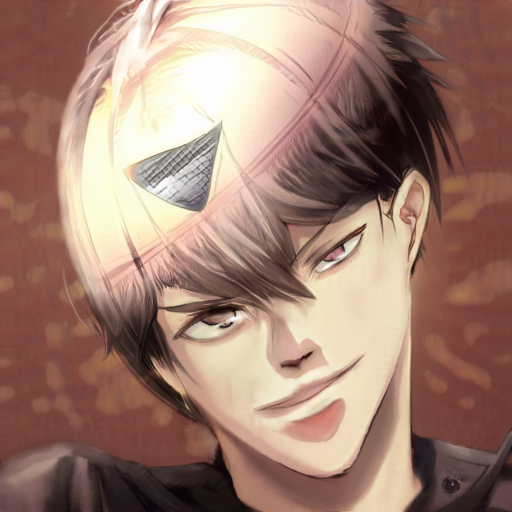

In [ ]:
results=searchAndClimb("a girl wearing glasses",1000,10,100,show=True)

In [ ]:
results=searchAndClimb("a girl wearing a hat",1000,10,100,show=True)

In [ ]:
def displayLatent(latent,phi=1.0):
    with torch.no_grad():
      img_pt, _ = g(
          [torch.from_numpy(latent).to(device)],
          truncation=phi,
          truncation_latent=latent_avg.to(device),
          randomize_noise=False,
      )
    img=img_pt.cpu().numpy()[0]
    return fmtImg(img)

In [ ]:
def showResults(results):
  img = PIL.Image.fromarray(np.hstack([np.array(displayLatent(r)) for (r,s) in results]), 'RGB')
  return img

In [ ]:
results=searchAndClimb("a girl holding an umbrella",1000,10,100)
showResults(results)

In [ ]:
results=searchAndClimb("a girl wearing a white wedding dress",1000,10,100,show=True)
